# Deep Learning On CIFAR10
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. (source https://www.cs.toronto.edu/~kriz/cifar.html)

Example images for each category are as follows
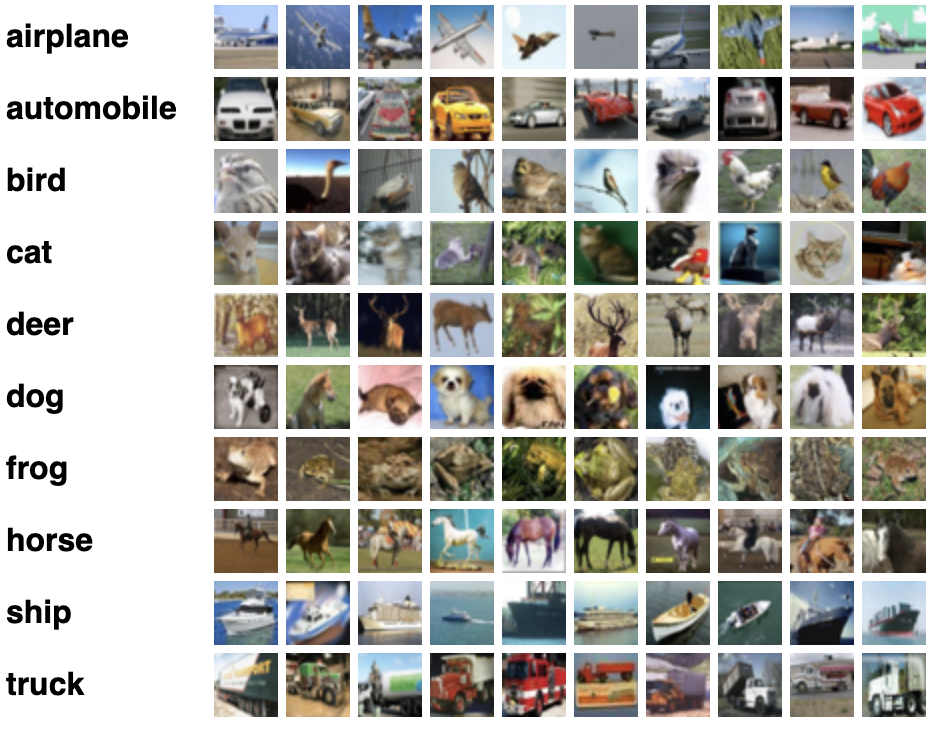



For this notebook, we will build a simple DNN for classification and we will use the Keras API.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

In [2]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
with tf.device("/device:GPU:0"):
  for _ in range(20):
      model.add(keras.layers.Dense(100,
                                  activation="elu",
                                  kernel_initializer="he_normal"))
  model.add(keras.layers.Dense(10, activation="softmax"))

Let's load the CIFAR10 dataset. We also want to use early stopping, so we need a validation set. Let's use the first 5,000 images of the original training set as the validation set:

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

Now we can create the callbacks we need and train the model:


In [4]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

We use a Nadam optimizer with a learning rate of 5e-5. I tried a few combinations offline and that's the best option.


In [5]:
optimizer = keras.optimizers.Nadam(lr=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/100
   1/1407 [..............................] - ETA: 0s - loss: 165.9660 - accuracy: 0.0625WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1407/1407 [==============================] - 15s 11ms/step - loss: 3.9413 - accuracy: 0.1656 - val_loss: 2.1444 - val_accuracy: 0.2346
Epoch 2/100
1407/1407 [==============================] - 15s 11ms/step - loss: 2.0385 - accuracy: 0.2538 - val_loss: 2.0249 - val_accuracy: 0.2626
Epoch 3/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.9138 - accuracy: 0.2994 - val_loss: 1.9359 - val_accuracy: 0.2932
Epoch 4/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.8400 - accuracy: 0.3304 - val_loss: 1.8402 - val_accuracy: 0.3390
Epoch 5/100
1407/1407 [=======================

In [6]:
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 3ms/step - loss: 1.5349 - accuracy: 0.4734


[1.5349048376083374, 0.4733999967575073]

The model with the lowest validation loss gets about 47% accuracy on the validation set. It took 47 epochs to reach the lowest validation loss. Let's see if we can improve performance using Batch Normalization.

In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)
model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 43s 31ms/step - loss: 1.8407 - accuracy: 0.3394 - val_loss: 1.6790 - val_accuracy: 0.3980
Epoch 2/100
1407/1407 [==============================] - 42s 30ms/step - loss: 1.6675 - accuracy: 0.4077 - val_loss: 1.6179 - val_accuracy: 0.4228
Epoch 3/100
1407/1407 [==============================] - 42s 30ms/step - loss: 1.5981 - accuracy: 0.4310 - val_loss: 1.5594 - val_accuracy: 0.4320
Epoch 4/100
1407/1407 [==============================] - 42s 30ms/step - loss: 1.5477 - accuracy: 0.4489 - val_loss: 1.4964 - val_accuracy: 0.4690
Epoch 5/100
1407/1407 [==============================] - 41s 29ms/step - loss: 1.5046 - accuracy: 0.4644 - val_loss: 1.4306 - val_accuracy: 0.4850
Epoch 6/100
1407/1407 [==============================] - 41s 29ms/step - loss: 1.4681 - accuracy: 0.4752 - val_loss: 1.4333 - val_accuracy: 0.4870
Epoch 7/100
1407/1407 [==============================] - 40s 28ms/step - loss: 1.4366 - accuracy: 0.4888 - val_loss: 1

[1.3252134323120117, 0.08879999816417694]

Does BN produce a better model? Yes! The final model is also much better, with 52% accuracy instead of 47%. It's still not a very good model, but at least it's much better than before (a Convolutional Neural Network would do much better though)